<a href="https://colab.research.google.com/github/criscarmor/TFG-CCM/blob/main/DEFINITIVO_Predicci%C3%B3n_secuenciales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este Notebook se encarga de generar los datasets necesarios para entrenar los distintos modelos.

Para comenzar hay que subir 2 archivos:

*   **X_data_final.csv** (donde X indica el contaminante)
*   **clima_data_final.csv** (archivo con los datos de clima horarios)

En la primera línea de código, elegir la estación objetivo de estudio y el contaminante. Hay que tener en cuenta que no todas las estaciones están disponibles para todos los contaminantes.

*   **NO2**: [9, 10, 15, 16, 17, 18, 19]
*   **O3**: [9, 15, 17, 18, 19]
*   **SO2**: [9, 10, 16, 18, 19]
*   **PM10**: [9, 15, 16, 18]
*   **PM25**: [9, 10, 15]

In [ ]:
estacion = 19
contaminante = 'SO2'

In [ ]:
!pip install keras-tcn

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tcn import TCN
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def merge_por_estacion(df_contaminacion, df_clima):

    estaciones = df_contaminacion['ESTACION'].unique()
    resultados = {}

    for est in estaciones:
        df_est = df_contaminacion[df_contaminacion['ESTACION'] == est]
        df_merged = df_est.merge(df_clima, left_index=True, right_index=True, how='inner')
        df_merged.drop(columns=['ESTACION'], inplace=True)
        resultados[est] = df_merged

    return resultados

In [ ]:
def detectar_bloques_continuos(df, min_horas=25):
    """
    Detecta bloques de tiempo consecutivo (1h de diferencia entre filas)
    con al menos `min_horas` observaciones.
    """
    df = df.sort_index()
    idx = df.index

    # Calcular diferencias entre fechas
    dif = idx.to_series().diff().fillna(pd.Timedelta(hours=1))
    corte = dif != pd.Timedelta(hours=1)

    # Etiquetar bloques de continuidad
    bloques = corte.cumsum()

    # Agrupar por bloques y filtrar los que tienen duración suficiente
    bloques_validos = []
    for _, grupo in df.groupby(bloques):
        if len(grupo) >= min_horas:
            bloques_validos.append(grupo)

    return bloques_validos

In [ ]:
def dividir_en_bloques_continuos(df):
    df = df.sort_index()
    # Calcular la diferencia horaria entre filas consecutivas
    diffs = df.index.to_series().diff()

    # Identificar inicio de nuevos bloques donde hay salto ≠ 1 hora
    bloques_id = (diffs != pd.Timedelta(hours=1)).cumsum()

    # Agrupar en bloques
    bloques = df.groupby(bloques_id)
    bloques_lista = [grupo for _, grupo in bloques]

    return bloques_lista

In [ ]:
def crear_secuencias_multivariadas_debug(bloques, columnas_X, window_size, scaler_continuas):
    import numpy as np

    X_total, y_total = [], []
    printed = False

    # Separar columnas
    columnas_ciclicas = [col for col in columnas_X if 'sin' in col or 'cos' in col]
    columnas_continuas = [col for col in columnas_X if col not in columnas_ciclicas]

    # Validación de seguridad
    if hasattr(scaler_continuas, 'feature_names_in_'):
        assert list(scaler_continuas.feature_names_in_) == columnas_continuas, \
            f" Las columnas continuas no coinciden con las usadas para entrenar el scaler:\n" \
            f"Esperadas: {list(scaler_continuas.feature_names_in_)}\n" \
            f"Recibidas: {columnas_continuas}"

    for i_bloque, bloque in enumerate(bloques):
        bloque = bloque.asfreq('H')

        # Filtrar bloques cortos o con NaN
        if len(bloque) <= window_size:
            continue
        if bloque[columnas_X].isna().any().any():
            continue

        bloque = bloque.copy()

        # Escalar las columnas continuas (NO2 + clima)
        continuas_scaled = scaler_continuas.transform(bloque[columnas_continuas])
        ciclicas = bloque[columnas_ciclicas].values

        # Concatenar respetando el orden original
        X_vals = np.hstack([continuas_scaled, ciclicas])

        # Target (solo NO2, primera columna de las continuas)
        y_vals = continuas_scaled[:, 0]

        for i in range(len(bloque) - window_size - 1):
            x_seq = X_vals[i:i + window_size]
            y_val = y_vals[i + window_size]

            X_total.append(x_seq)
            y_total.append(y_val)

            if not printed:
                print(f"\n Bloque {i_bloque} — Primera secuencia generada:")
                fechas_seq = bloque.index[i : i + window_size]

                # Desescalar NO2 y clima para impresión
                x_seq_continuas_descalado = scaler_continuas.inverse_transform(x_seq[:, :len(columnas_continuas)])
                x_seq_no2 = x_seq_continuas_descalado[:, 0]
                x_seq_clima = x_seq_continuas_descalado[:, 1:]
                x_seq_ciclicas = x_seq[:, len(columnas_continuas):]

                for j in range(window_size):
                    paso = j - (window_size - 1)
                    label = f"t{paso}" if paso < 0 else "t0"
                    print(f"  {label} ({fechas_seq[j]}) → CONCENTRACION: {x_seq_no2[j]:.2f}, "
                          f"Clima: {np.round(x_seq_clima[j], 2).tolist()}, "
                          f"Cíclicas: {np.round(x_seq_ciclicas[j], 3).tolist()}")

                y_val_input = np.hstack([[y_val], np.zeros(len(columnas_continuas) - 1)])
                y_val_descalado = scaler_continuas.inverse_transform(y_val_input.reshape(1, -1))[0][0]

                print(f" Target (t+1) ({bloque.index[i + window_size]}) → CONCENTRACION: {y_val_descalado:.2f}")
                printed = True

    X_total = np.array(X_total)
    y_total = np.array(y_total)

    print(f"\n Total de secuencias generadas: {X_total.shape[0]}")
    return X_total, y_total


In [ ]:
def crear_secuencias_multisalida(bloques, columnas_X, window_size, horizon, scaler_continuas):
    X_total, y_total = [], []
    columnas_ciclicas = [col for col in columnas_X if 'sin' in col or 'cos' in col]
    columnas_continuas = [col for col in columnas_X if col not in columnas_ciclicas]

    for bloque in bloques:
        bloque = bloque.asfreq('H')
        if len(bloque) <= window_size + horizon:
            continue
        if bloque[columnas_X].isna().any().any():
            continue

        bloque = bloque.copy()
        continuas_scaled = scaler_continuas.transform(bloque[columnas_continuas])
        ciclicas = bloque[columnas_ciclicas].values
        X_vals = np.hstack([continuas_scaled, ciclicas])

        no2_scaled = continuas_scaled[:, 0]

        for i in range(len(bloque) - window_size - horizon + 1):
            x_seq = X_vals[i : i + window_size]
            y_seq = no2_scaled[i + window_size : i + window_size + horizon]

            X_total.append(x_seq)
            y_total.append(y_seq)

    X_total = np.array(X_total)
    y_total = np.array(y_total)

    print(f"\n Total de secuencias generadas: {X_total.shape[0]} | Salidas por muestra: {y_total.shape[1]}")
    return X_total, y_total

In [ ]:
def desescalar_salida_multistep(y_scaled, scaler, columnas_continuas):
    """
    Desescala una matriz (n_samples, horizon) de predicciones de NO2
    usando el scaler ajustado sobre NO2 + clima.
    """
    n_samples, horizon = y_scaled.shape
    y_inv = []

    for i in range(horizon):
        paso_i = y_scaled[:, i].reshape(-1, 1)
        paso_i_padded = np.hstack([
            paso_i, np.zeros((n_samples, len(columnas_continuas) - 1))
        ])
        paso_i_descalado = scaler.inverse_transform(paso_i_padded)[:, 0]
        y_inv.append(paso_i_descalado)

    return np.stack(y_inv, axis=1)

# Carga


In [ ]:
df = pd.read_csv(contaminante + "_data_final.csv", index_col=0, parse_dates=True)
df

,ESTACION,CONCENTRACION,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos
FECHA_HORA,,,,,,,,
2014-01-01 00:00:00,9.0,8.0,0.000000,1.000000,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 01:00:00,9.0,8.0,0.258819,0.965926,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 02:00:00,9.0,7.0,0.500000,0.866025,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 03:00:00,9.0,5.0,0.707107,0.707107,0.974928,-0.222521,5.000000e-01,0.866025
2014-01-01 04:00:00,9.0,5.0,0.866025,0.500000,0.974928,-0.222521,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,19.0,5.0,-0.965926,0.258819,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 20:00:00,19.0,5.0,-0.866025,0.500000,-0.781831,0.623490,-2.449294e-16,1.000000
2023-12-31 21:00:00,19.0,5.0,-0.707107,0.707107,-0.781831,0.623490,-2.449294e-16,1.000000


In [ ]:
df_clima = pd.read_csv("clima_data_final.csv", index_col=0, parse_dates=True)
df_clima

,temp,dwpt,rhum,wspd,prcp,wdir_sin,wdir_cos
FECHA_HORA,,,,,,,
2014-01-02 00:00:00,13.900000,13.3,97.000000,11.2,0.0,-6.427876e-01,-0.766044
2014-01-02 01:00:00,13.966667,13.3,96.666667,12.4,0.0,-6.838732e-01,-0.724959
2014-01-02 02:00:00,14.033333,13.3,96.333333,13.6,0.0,-7.249588e-01,-0.683873
2014-01-02 03:00:00,14.100000,13.3,96.000000,14.8,0.0,-7.660444e-01,-0.642788
2014-01-02 04:00:00,14.000000,14.0,100.000000,13.0,0.0,-5.000000e-01,-0.866025
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,9.500000,9.5,100.000000,7.6,0.0,5.000000e-01,0.866025
2023-12-31 20:00:00,9.300000,9.3,100.000000,3.6,0.0,1.736482e-01,0.984808
2023-12-31 21:00:00,7.900000,7.9,100.000000,5.4,0.0,-2.449294e-16,1.000000


In [ ]:
df_estaciones = merge_por_estacion(df, df_clima)

# Cálculo cutoff


In [ ]:
cutoff_2023 = pd.Timestamp("2023-01-01 00:00:00")

In [ ]:
df = df_estaciones[estacion][df_estaciones[estacion].index < cutoff_2023].copy()
df_2023 = df_estaciones[estacion][df_estaciones[estacion].index >= cutoff_2023 + pd.Timedelta(days=2)].copy()

# Generación secuencias 1 hora


In [ ]:
bloques_original = dividir_en_bloques_continuos(df)
bloques_filtrados = [b for b in bloques_original if len(b) > 24]
print(f" Bloques: {len(bloques_filtrados)}")

✅ Bloques: 41


In [ ]:
columnas_X = ['CONCENTRACION', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos',
              'mes_sin', 'mes_cos', 'temp', 'dwpt', 'rhum', 'wdir_sin','wdir_cos', 'wspd','prcp']

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Crear scaler conjunto para NO2 + clima
columnas_ciclicas = [col for col in columnas_X if 'sin' in col or 'cos' in col]
columnas_continuas = [col for col in columnas_X if col not in columnas_ciclicas]

scaler_continuas = RobustScaler()
scaler_continuas.fit(df[columnas_continuas])

# Crear secuencias
X, y = crear_secuencias_multivariadas_debug(
    bloques_filtrados, columnas_X, window_size=24, scaler_continuas=scaler_continuas
)



 Bloque 0 — Primera secuencia generada:
  t-23 (2014-01-02 00:00:00) → CONCENTRACION: 2.00, Clima: [13.9, 13.3, 97.0, 11.2, 0.0], Cíclicas: [0.0, 1.0, 0.434, -0.901, 0.5, 0.866, -0.643, -0.766]
  t-22 (2014-01-02 01:00:00) → CONCENTRACION: 2.00, Clima: [13.97, 13.3, 96.67, 12.4, 0.0], Cíclicas: [0.259, 0.966, 0.434, -0.901, 0.5, 0.866, -0.684, -0.725]
  t-21 (2014-01-02 02:00:00) → CONCENTRACION: 2.00, Clima: [14.03, 13.3, 96.33, 13.6, 0.0], Cíclicas: [0.5, 0.866, 0.434, -0.901, 0.5, 0.866, -0.725, -0.684]
  t-20 (2014-01-02 03:00:00) → CONCENTRACION: 2.00, Clima: [14.1, 13.3, 96.0, 14.8, 0.0], Cíclicas: [0.707, 0.707, 0.434, -0.901, 0.5, 0.866, -0.766, -0.643]
  t-19 (2014-01-02 04:00:00) → CONCENTRACION: 2.00, Clima: [14.0, 14.0, 100.0, 13.0, 0.0], Cíclicas: [0.866, 0.5, 0.434, -0.901, 0.5, 0.866, -0.5, -0.866]
  t-18 (2014-01-02 05:00:00) → CONCENTRACION: 3.00, Clima: [14.0, 14.0, 100.0, 7.6, 0.0], Cíclicas: [0.966, 0.259, 0.434, -0.901, 0.5, 0.866, -0.342, -0.94]
  t-17 (2014-01-0

/tmp/ipython-input-7-1885871567.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipython-input-7-1885871567.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipython-input-7-1885871567.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipython-input-7-1885871567.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipython-input-7-1885871567.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipython-input-7-1885871567.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H'


 Total de secuencias generadas: 74935


In [ ]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # sin mezcla por ser serie temporal
)

In [ ]:
y_test = y_test[48:] # PARA EVITAR SOLAPAMIENTO
X_test = X_test[48:]

In [ ]:
bloques_2023 = dividir_en_bloques_continuos(df_2023)
bloques_2023 = [b for b in bloques_2023 if len(b) > 24]

In [ ]:
X_2023, y_2023 = crear_secuencias_multivariadas_debug(
    bloques_2023, columnas_X, window_size=24, scaler_continuas=scaler_continuas
)


 Bloque 0 — Primera secuencia generada:
  t-23 (2023-01-03 00:00:00) → CONCENTRACION: 3.00, Clima: [9.9, 9.9, 100.0, 7.6, 0.0], Cíclicas: [0.0, 1.0, 0.782, 0.623, 0.5, 0.866, -0.174, 0.985]
  t-22 (2023-01-03 01:00:00) → CONCENTRACION: 2.00, Clima: [9.4, 9.2, 99.0, 0.0, 0.0], Cíclicas: [0.259, 0.966, 0.782, 0.623, 0.5, 0.866, 0.0, 1.0]
  t-21 (2023-01-03 02:00:00) → CONCENTRACION: 2.00, Clima: [9.0, 9.0, 100.0, 3.6, 0.0], Cíclicas: [0.5, 0.866, 0.782, 0.623, 0.5, 0.866, 0.342, 0.94]
  t-20 (2023-01-03 03:00:00) → CONCENTRACION: 2.00, Clima: [8.7, 8.3, 98.0, 3.6, 0.0], Cíclicas: [0.707, 0.707, 0.782, 0.623, 0.5, 0.866, 0.174, 0.985]
  t-19 (2023-01-03 04:00:00) → CONCENTRACION: 2.00, Clima: [8.2, 7.4, 96.0, 5.4, 0.0], Cíclicas: [0.866, 0.5, 0.782, 0.623, 0.5, 0.866, -0.5, 0.866]
  t-18 (2023-01-03 05:00:00) → CONCENTRACION: 3.00, Clima: [8.7, 7.1, 92.0, 11.2, 0.0], Cíclicas: [0.966, 0.259, 0.782, 0.623, 0.5, 0.866, -0.174, 0.985]
  t-17 (2023-01-03 06:00:00) → CONCENTRACION: 3.00, Clim

/tmp/ipython-input-7-1885871567.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')


# Generación secuencias 24 horas

In [ ]:
X_24, y_24 = crear_secuencias_multisalida(bloques_filtrados, columnas_X, window_size=24, horizon=24, scaler_continuas=scaler_continuas)

/tmp/ipython-input-8-741046584.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipython-input-8-741046584.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipython-input-8-741046584.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipython-input-8-741046584.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipython-input-8-741046584.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipython-input-8-741046584.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')
/tmp/ipyth


 Total de secuencias generadas: 74033 | Salidas por muestra: 24


In [ ]:
from sklearn.model_selection import train_test_split

X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(
    X_24, y_24, test_size=0.2, shuffle=False  # sin shuffle para mantener la secuencia temporal
)


In [ ]:
y_test_24 = y_test_24[48:] # PARA EVITAR SOLAPAMIENTO
X_test_24 = X_test_24[48:]

In [ ]:
X_2023_24, y_2023_24 = crear_secuencias_multisalida(bloques_2023, columnas_X, window_size=24, horizon=24, scaler_continuas=scaler_continuas)


 Total de secuencias generadas: 8665 | Salidas por muestra: 24


/tmp/ipython-input-8-741046584.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bloque = bloque.asfreq('H')


#LSTM predicción 1 hora

In [ ]:

# DEFINICIÓN DE MODELOS

def build_simple_lstm(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(1)
    ])
    return model

def build_stacked_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32),
        Dense(1)
    ])
    return model

def build_dropout_dense_lstm(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

# CONFIGURACIÓN DE MODELOS A EVALUAR

model_builders = {
    'Simple_LSTM': build_simple_lstm,
    'Stacked_LSTM': build_stacked_lstm,
    'Dropout_Dense_LSTM': build_dropout_dense_lstm
}

# ENTRENAMIENTO Y VALIDACIÓN

results = {}

for name, build_fn in model_builders.items():
    print(f"\n Entrenando modelo: {name}")
    model = build_fn(input_shape=X_train.shape[1:])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )


    # VALIDACIÓN INTERMEDIA (val)

    val_loss, val_mae = model.evaluate(X_test, y_test, verbose=0)


    # PREDICCIÓN FINAL EN 2023

    y_pred_2023 = model.predict(X_2023).flatten()

    # Desescalado para comparación en unidades reales
    y_test_input_2023 = np.hstack([
        y_2023.reshape(-1, 1),
        np.zeros((len(y_2023), len(columnas_continuas) - 1))
    ])

    y_pred_input_2023 = np.hstack([
        y_pred_2023.reshape(-1, 1),
        np.zeros((len(y_pred_2023), len(columnas_continuas) - 1))
    ])

    y_test_inv_2023 = scaler_continuas.inverse_transform(y_test_input_2023)[:, 0]
    y_pred_inv_2023 = scaler_continuas.inverse_transform(y_pred_input_2023)[:, 0]

    # Métricas finales
    rmse_2023 = np.sqrt(mean_squared_error(y_test_inv_2023, y_pred_inv_2023))
    mae_2023 = mean_absolute_error(y_test_inv_2023, y_pred_inv_2023)
    r2_2023 = r2_score(y_test_inv_2023, y_pred_inv_2023)


    # GUARDAR RESULTADOS

    results[name] = {
    'val_loss': val_loss,
    'val_mae': val_mae,
    'rmse_2023': rmse_2023,
    'mae_2023': mae_2023,
    'r2_2023': r2_2023,
    'y_test': y_test_inv_2023,
    'y_pred': y_pred_inv_2023,
    'history': history
    }

    print(f" {name} - Val MSE: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
    print(f" {name} - 2023 RMSE: {rmse_2023:.4f}, MAE: {mae_2023:.4f}, R²: {r2_2023:.4f}")



🔁 Entrenando modelo: Simple_LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Simple_LSTM - Val MSE: 0.2993, Val MAE: 0.2493
📊 Simple_LSTM - 2023 RMSE: 0.3954, MAE: 0.2587, R²: 0.7009

🔁 Entrenando modelo: Stacked_LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Stacked_LSTM - Val MSE: 0.3083, Val MAE: 0.2572
📊 Stacked_LSTM - 2023 RMSE: 0.4038, MAE: 0.2732, R²: 0.6880

🔁 Entrenando modelo: Dropout_Dense_LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Dropout_Dense_LSTM - Val MSE: 0.2871, Val MAE: 0.2496
📊 Dropout_Dense_LSTM - 2023 RMSE: 0.3882, MAE: 0.2482, R²: 0.7116


In [ ]:
mejor_modelo = max(results, key=lambda k: results[k]['r2_2023'])
y_pred_inv_2023 = results[mejor_modelo]['y_pred']
y_test_inv_2023 = results[mejor_modelo]['y_test']

In [ ]:
bloques_2023_plot = detectar_bloques_continuos(df_2023, 20)
bloque_2023_plot = bloques_2023_plot[0]

In [ ]:

# Obtenemos los índices del bloque
indices_bloque = bloque_2023_plot.index

# Buscamos las posiciones en el DataFrame original
posiciones = df_2023.index.get_indexer(indices_bloque)
validas = posiciones[posiciones < len(y_pred_inv_2023)]
#obtenemos las predicciones correspondientes
predicciones_bloque = y_pred_inv_2023[validas]
real_bloque = y_test_inv_2023[validas]

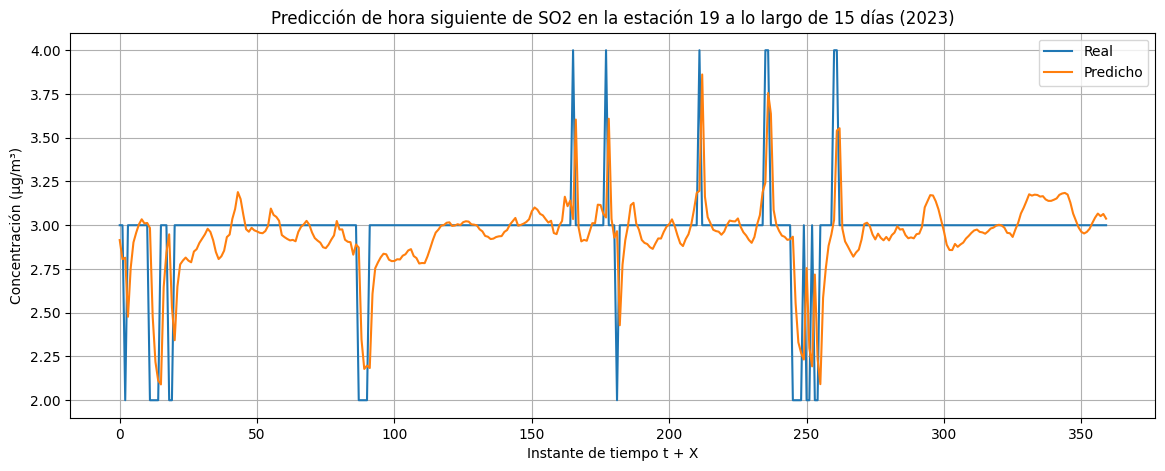

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(real_bloque[:360], label='Real')
plt.plot(predicciones_bloque[:360], label='Predicho')
plt.title("Predicción de hora siguiente de " + contaminante +" en la estación " + str(estacion) + " a lo largo de 15 días (2023)")
plt.xlabel("Instante de tiempo t + X")
plt.ylabel("Concentración (μg/m³)")
plt.legend()
plt.grid(True)
plt.show()

#GRU predicción 1 hora

In [ ]:
# DEFINICIÓN DE MODELOS

def build_simple_gru(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dense(1)
    ])
    return model

def build_stacked_gru(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        GRU(32),
        Dense(1)
    ])
    return model

def build_dropout_dense_gru(input_shape):
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model


# CONFIGURACIÓN DE MODELOS A EVALUAR

model_builders = {
    'Simple_GRU': build_simple_gru,
    'Stacked_GRU': build_stacked_gru,
    'Dropout_Dense_GRU': build_dropout_dense_gru
}


# ENTRENAMIENTO Y VALIDACIÓN

results = {}

for name, build_fn in model_builders.items():
    print(f"\n Entrenando modelo: {name}")
    model = build_fn(input_shape=X_train.shape[1:])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )


    # VALIDACIÓN INTERMEDIA (val)

    val_loss, val_mae = model.evaluate(X_test, y_test, verbose=0)


    # PREDICCIÓN FINAL EN 2023

    y_pred_2023 = model.predict(X_2023).flatten()

    # Desescalado para comparación en unidades reales
    y_test_input_2023 = np.hstack([
        y_2023.reshape(-1, 1),
        np.zeros((len(y_2023), len(columnas_continuas) - 1))
    ])

    y_pred_input_2023 = np.hstack([
        y_pred_2023.reshape(-1, 1),
        np.zeros((len(y_pred_2023), len(columnas_continuas) - 1))
    ])

    y_test_inv_2023 = scaler_continuas.inverse_transform(y_test_input_2023)[:, 0]
    y_pred_inv_2023 = scaler_continuas.inverse_transform(y_pred_input_2023)[:, 0]

    # Métricas finales
    rmse_2023 = np.sqrt(mean_squared_error(y_test_inv_2023, y_pred_inv_2023))
    mae_2023 = mean_absolute_error(y_test_inv_2023, y_pred_inv_2023)
    r2_2023 = r2_score(y_test_inv_2023, y_pred_inv_2023)


    # GUARDAR RESULTADOS

    results[name] = {
    'val_loss': val_loss,
    'val_mae': val_mae,
    'rmse_2023': rmse_2023,
    'mae_2023': mae_2023,
    'r2_2023': r2_2023,
    'y_test': y_test_inv_2023,
    'y_pred': y_pred_inv_2023,
    'history': history
    }

    print(f" {name} - Val MSE: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
    print(f" {name} - 2023 RMSE: {rmse_2023:.4f}, MAE: {mae_2023:.4f}, R²: {r2_2023:.4f}")



🔁 Entrenando modelo: Simple_GRU


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Simple_GRU - Val MSE: 0.3023, Val MAE: 0.2489
📊 Simple_GRU - 2023 RMSE: 0.3845, MAE: 0.2475, R²: 0.7171

🔁 Entrenando modelo: Stacked_GRU


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Stacked_GRU - Val MSE: 0.3084, Val MAE: 0.2390
📊 Stacked_GRU - 2023 RMSE: 0.3851, MAE: 0.2488, R²: 0.7163

🔁 Entrenando modelo: Dropout_Dense_GRU


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Dropout_Dense_GRU - Val MSE: 0.3077, Val MAE: 0.2426
📊 Dropout_Dense_GRU - 2023 RMSE: 0.3964, MAE: 0.2546, R²: 0.6993


In [ ]:
mejor_modelo = max(results, key=lambda k: results[k]['r2_2023'])
y_pred_inv_2023 = results[mejor_modelo]['y_pred']
y_test_inv_2023 = results[mejor_modelo]['y_test']

In [ ]:
bloques_2023_plot = detectar_bloques_continuos(df_2023, 20)
bloque_2023_plot = bloques_2023_plot[0]

In [ ]:

# Obtenemos los índices del bloque
indices_bloque = bloque_2023_plot.index

# Buscamos las posiciones en el original
posiciones = df_2023.index.get_indexer(indices_bloque)
validas = posiciones[posiciones < len(y_pred_inv_2023)]
#obtenemos las predicciones correspondientes
predicciones_bloque = y_pred_inv_2023[validas]
real_bloque = y_test_inv_2023[validas]

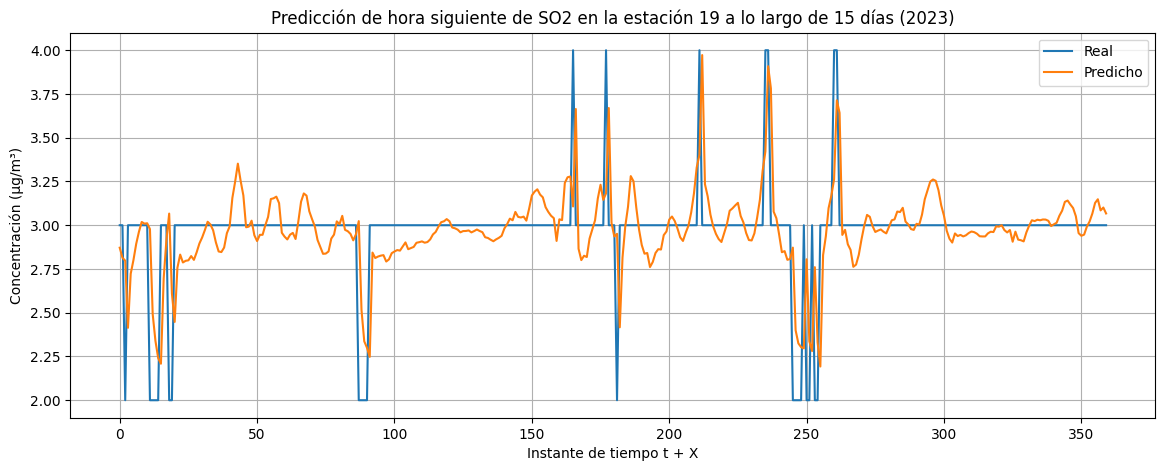

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(real_bloque[:360], label='Real')
plt.plot(predicciones_bloque[:360], label='Predicho')
plt.title("Predicción de hora siguiente de " + contaminante +" en la estación " + str(estacion) + " a lo largo de 15 días (2023)")
plt.xlabel("Instante de tiempo t + X")
plt.ylabel("Concentración (μg/m³)")
plt.legend()
plt.grid(True)
plt.show()

#TCN predicción 1 hora

In [ ]:
# DEFINICIÓN DE MODELOS

def build_simple_tcn(input_shape):
    model = Sequential([
        TCN(64, kernel_size=2, dilations=[1, 2, 4, 8, 9], input_shape=input_shape),
        Dense(1)
    ])
    return model

def build_stacked_tcn(input_shape):
    model = Sequential([
        TCN(64, kernel_size=2, dilations=[1, 2, 4], return_sequences=True, input_shape=input_shape),
        TCN(32, kernel_size=2, dilations=[1, 2, 4, 8, 9], return_sequences=False),
        Dense(1)
    ])
    return model

def build_dropout_dense_tcn(input_shape):
    model = Sequential([
        TCN(128, kernel_size=2, dilations=[1, 2, 4, 8], return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        TCN(64, kernel_size=2, dilations=[1, 2, 4, 8], return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model



# CONFIGURACIÓN DE MODELOS A EVALUAR

model_builders = {
    'Simple_TCN': build_simple_tcn,
    'Stacked_TCN': build_stacked_tcn,
    'Dropout_Dense_TCN': build_dropout_dense_tcn
}


# ENTRENAMIENTO Y VALIDACIÓN

results = {}

for name, build_fn in model_builders.items():
    print(f"\n Entrenando modelo: {name}")
    model = build_fn(input_shape=X_train.shape[1:])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )


    # VALIDACIÓN INTERMEDIA (val)

    val_loss, val_mae = model.evaluate(X_test, y_test, verbose=0)


    # PREDICCIÓN FINAL EN 2023

    y_pred_2023 = model.predict(X_2023).flatten()

    # Desescalado para comparación en unidades reales
    y_test_input_2023 = np.hstack([
        y_2023.reshape(-1, 1),
        np.zeros((len(y_2023), len(columnas_continuas) - 1))
    ])

    y_pred_input_2023 = np.hstack([
        y_pred_2023.reshape(-1, 1),
        np.zeros((len(y_pred_2023), len(columnas_continuas) - 1))
    ])

    y_test_inv_2023 = scaler_continuas.inverse_transform(y_test_input_2023)[:, 0]
    y_pred_inv_2023 = scaler_continuas.inverse_transform(y_pred_input_2023)[:, 0]

    # Métricas finales
    rmse_2023 = np.sqrt(mean_squared_error(y_test_inv_2023, y_pred_inv_2023))
    mae_2023 = mean_absolute_error(y_test_inv_2023, y_pred_inv_2023)
    r2_2023 = r2_score(y_test_inv_2023, y_pred_inv_2023)


    # GUARDAR RESULTADOS

    results[name] = {
    'val_loss': val_loss,
    'val_mae': val_mae,
    'rmse_2023': rmse_2023,
    'mae_2023': mae_2023,
    'r2_2023': r2_2023,
    'y_test': y_test_inv_2023,
    'y_pred': y_pred_inv_2023,
    'history': history
    }

    print(f" {name} - Val MSE: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
    print(f" {name} - 2023 RMSE: {rmse_2023:.4f}, MAE: {mae_2023:.4f}, R²: {r2_2023:.4f}")



🔁 Entrenando modelo: Simple_TCN


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
✅ Simple_TCN - Val MSE: 0.2865, Val MAE: 0.2608
📊 Simple_TCN - 2023 RMSE: 0.4004, MAE: 0.2694, R²: 0.6932

🔁 Entrenando modelo: Stacked_TCN


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
✅ Stacked_TCN - Val MSE: 0.2847, Val MAE: 0.2542
📊 Stacked_TCN - 2023 RMSE: 0.3984, MAE: 0.2572, R²: 0.6963

🔁 Entrenando modelo: Dropout_Dense_TCN


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
✅ Dropout_Dense_TCN - Val MSE: 0.2889, Val MAE: 0.2605
📊 Dropout_Dense_TCN - 2023 RMSE: 0.3928, MAE: 0.2543, R²: 0.7047


In [ ]:
mejor_modelo = max(results, key=lambda k: results[k]['r2_2023'])
y_pred_inv_2023 = results[mejor_modelo]['y_pred']
y_test_inv_2023 = results[mejor_modelo]['y_test']

In [ ]:
bloques_2023_plot = detectar_bloques_continuos(df_2023, 20)
bloque_2023_plot = bloques_2023_plot[0]

In [ ]:

# Obtenemos los índices del bloque
indices_bloque = bloque_2023_plot.index

# Buscamos las posiciones en el original
posiciones = df_2023.index.get_indexer(indices_bloque)
validas = posiciones[posiciones < len(y_pred_inv_2023)]
#obtenemos las predicciones correspondientes
predicciones_bloque = y_pred_inv_2023[validas]
real_bloque = y_test_inv_2023[validas]

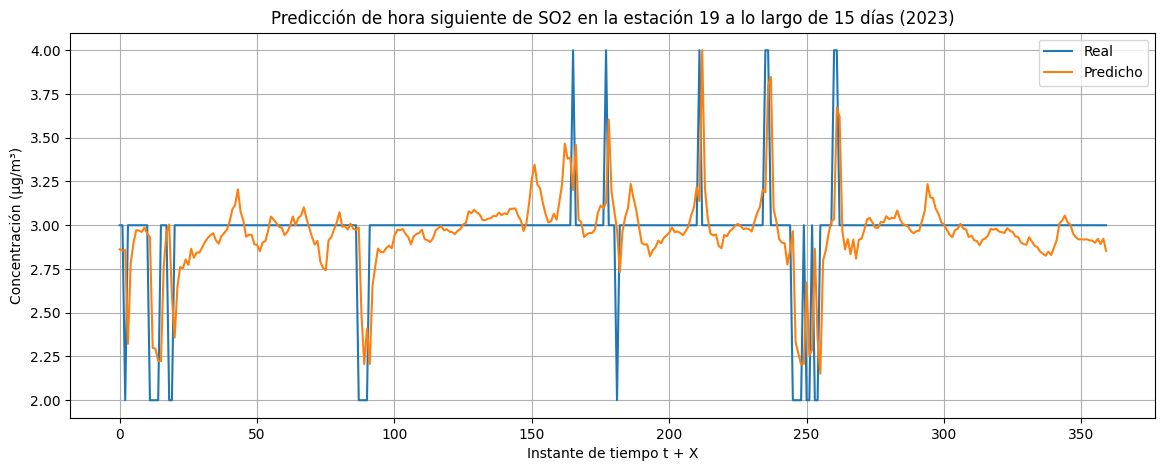

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(real_bloque[:360], label='Real')
plt.plot(predicciones_bloque[:360], label='Predicho')
plt.title("Predicción de hora siguiente de " + contaminante +" en la estación " + str(estacion) + " a lo largo de 15 días (2023)")
plt.xlabel("Instante de tiempo t + X")
plt.ylabel("Concentración (μg/m³)")
plt.legend()
plt.grid(True)
plt.show()

#LSTM predicción 24 horas

In [ ]:
# DEFINICIÓN DE MODELOS

def build_simple_lstm_dense24(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(24)
    ])
    return model

def build_stacked_lstm_dense24(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(64),
        Dense(24)
    ])
    return model

def build_dropout_lstm_dense24(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(24)
    ])
    return model


# CONFIGURACIÓN DE MODELOS A EVALUAR

model_builders = {
    'Simple_LSTM': build_simple_lstm_dense24,
    'Stacked_LSTM': build_stacked_lstm_dense24,
    'Dropout_Dense_LSTM': build_dropout_lstm_dense24
}


# ENTRENAMIENTO Y VALIDACIÓN

results = {}

for name, build_fn in model_builders.items():
    print(f"\n Entrenando modelo: {name}")
    model = build_fn(input_shape=(X_24.shape[1], X_24.shape[2]))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_24, y_train_24,
        validation_data=(X_test_24, y_test_24),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )


    # VALIDACIÓN INTERMEDIA (val)

    val_loss, val_mae = model.evaluate(X_test_24, y_test_24, verbose=0)


    # PREDICCIÓN FINAL EN 2023

    y_pred_2023_24 = model.predict(X_2023_24)
    y_pred_inv_2023_24 = desescalar_salida_multistep(y_pred_2023_24, scaler_continuas, columnas_continuas)
    y_2023_inv_2023_24 = desescalar_salida_multistep(y_2023_24, scaler_continuas, columnas_continuas)

    rmse_2023 = np.sqrt(mean_squared_error(y_2023_inv_2023_24, y_pred_inv_2023_24))
    mae_2023 = mean_absolute_error(y_2023_inv_2023_24, y_pred_inv_2023_24)
    r2_2023 = r2_score(y_2023_inv_2023_24, y_pred_inv_2023_24)


    # GUARDAR RESULTADOS

    results[name] = {
    'val_loss': val_loss,
    'val_mae': val_mae,
    'rmse_2023': rmse_2023,
    'mae_2023': mae_2023,
    'r2_2023': r2_2023,
    'y_test': y_2023_inv_2023_24,
    'y_pred': y_pred_inv_2023_24,
    'history': history
    }

    print(f" {name} - Val MSE: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
    print(f" {name} - 2023 RMSE: {rmse_2023:.4f}, MAE: {mae_2023:.4f}, R²: {r2_2023:.4f}")



🔁 Entrenando modelo: Simple_LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Simple_LSTM - Val MSE: 0.5028, Val MAE: 0.3862
📊 Simple_LSTM - 2023 RMSE: 0.5187, MAE: 0.3769, R²: 0.4831

🔁 Entrenando modelo: Stacked_LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Stacked_LSTM - Val MSE: 0.5114, Val MAE: 0.3877
📊 Stacked_LSTM - 2023 RMSE: 0.5522, MAE: 0.4048, R²: 0.4141

🔁 Entrenando modelo: Dropout_Dense_LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
✅ Dropout_Dense_LSTM - Val MSE: 0.5211, Val MAE: 0.3821
📊 Dropout_Dense_LSTM - 2023 RMSE: 0.6266, MAE: 0.4474, R²: 0.2456


#GRU predicción 24 horas

In [ ]:
# DEFINICIÓN DE MODELOS

def build_simple_gru_dense24(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dense(24)
    ])
    return model

def build_stacked_gru_dense24(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        GRU(64),
        Dense(24)
    ])
    return model

def build_dropout_gru_dense24(input_shape):
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(64),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(24)
    ])
    return model


# CONFIGURACIÓN DE MODELOS A EVALUAR

model_builders = {
    'Simple_GRU': build_simple_gru_dense24,
    'Stacked_GRU': build_stacked_gru_dense24,
    'Dropout_Dense_GRU': build_dropout_gru_dense24
}


# ENTRENAMIENTO Y VALIDACIÓN

results = {}

for name, build_fn in model_builders.items():
    print(f"\n Entrenando modelo: {name}")
    model = build_fn(input_shape=(X_24.shape[1], X_24.shape[2]))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_24, y_train_24,
        validation_data=(X_test_24, y_test_24),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )


    # VALIDACIÓN INTERMEDIA (val)

    val_loss, val_mae = model.evaluate(X_test_24, y_test_24, verbose=0)


    # PREDICCIÓN FINAL EN 2023

    y_pred_2023_24 = model.predict(X_2023_24)
    y_pred_inv_2023_24 = desescalar_salida_multistep(y_pred_2023_24, scaler_continuas, columnas_continuas)
    y_2023_inv_2023_24 = desescalar_salida_multistep(y_2023_24, scaler_continuas, columnas_continuas)

    rmse_2023 = np.sqrt(mean_squared_error(y_2023_inv_2023_24, y_pred_inv_2023_24))
    mae_2023 = mean_absolute_error(y_2023_inv_2023_24, y_pred_inv_2023_24)
    r2_2023 = r2_score(y_2023_inv_2023_24, y_pred_inv_2023_24)

    # GUARDAR RESULTADOS

    results[name] = {
    'val_loss': val_loss,
    'val_mae': val_mae,
    'rmse_2023': rmse_2023,
    'mae_2023': mae_2023,
    'r2_2023': r2_2023,
    'y_test': y_2023_inv_2023_24,
    'y_pred': y_pred_inv_2023_24,
    'history': history
    }

    print(f" {name} - Val MSE: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
    print(f" {name} - 2023 RMSE: {rmse_2023:.4f}, MAE: {mae_2023:.4f}, R²: {r2_2023:.4f}")



🔁 Entrenando modelo: Simple_GRU


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Simple_GRU - Val MSE: 0.5012, Val MAE: 0.3893
📊 Simple_GRU - 2023 RMSE: 0.5249, MAE: 0.3845, R²: 0.4707

🔁 Entrenando modelo: Stacked_GRU


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Stacked_GRU - Val MSE: 0.5043, Val MAE: 0.3961
📊 Stacked_GRU - 2023 RMSE: 0.5170, MAE: 0.3766, R²: 0.4863

🔁 Entrenando modelo: Dropout_Dense_GRU


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Dropout_Dense_GRU - Val MSE: 0.5190, Val MAE: 0.3823
📊 Dropout_Dense_GRU - 2023 RMSE: 0.5551, MAE: 0.4021, R²: 0.4079
